In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
from jax import numpy as jnp
from functools import partial
import optax
import matplotlib.pyplot as plt
import plotting
import sim
import optuna

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
study = optuna.load_study(
    study_name="qlearning",
    storage="sqlite:///qlearning4x4.db"
)
study.best_params

{'lr': 0.000371610810670586, 'annealing': 0.4601666091058003}

In [4]:
seed = 42
map_size = 4
max_interactions = 100_000
map_scale = int(jnp.log2(map_size))

# hyperparams
lr = study.best_params["lr"]
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8

# setup annealing schedules
dur = int(train_iter * n_rollouts * study.best_params["annealing"])
annealing_fn = optax.linear_schedule(1.0, 0.01, dur)

In [5]:
run_simulation = partial(
    sim.run_q_learning_simulation,
    map_size=map_size,
    n_rollouts=n_rollouts,
    rollout_length=rollout_length,
    train_iter=train_iter,
    lr=lr,
    annealing_fn=annealing_fn,
)
rng_key = jax.random.PRNGKey(seed)
env, dql_state, results = jax.vmap(run_simulation)(jax.random.split(rng_key, 8))

  0%|          | 0/3125 [00:00<?, ?it/s]

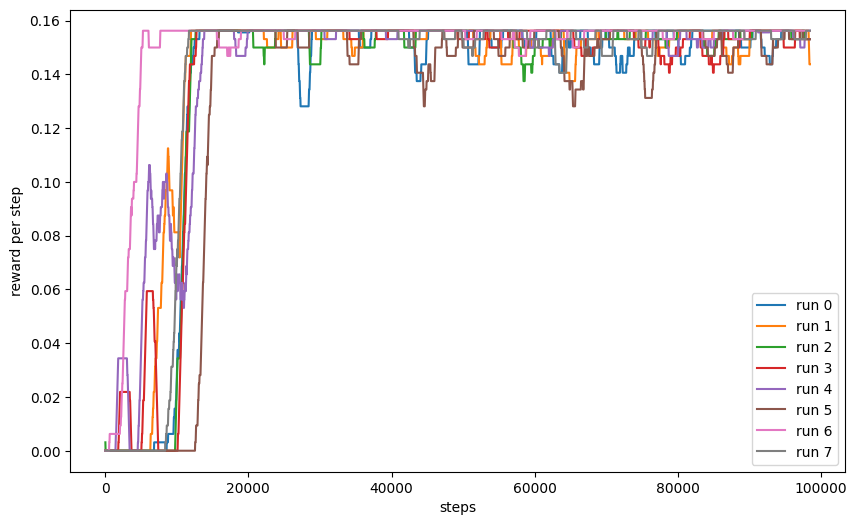

In [6]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")

plt.figure(figsize=(10, 6))
for i, (r, n) in enumerate(zip(results.eval_reward.sum(axis=-1), results.eval_done.sum(axis=-1))):
    r = smooth(r) / results.eval_reward.shape[-1]
    plt.plot(results.eval_reward.shape[-1]*jnp.arange(1,1+len(r)), r, label=f"run {i}")
# for i, (r, n) in enumerate(zip(results.expl_reward.sum(axis=-1), results.expl_done.sum(axis=-1))):
#     r = smooth(r) / results.expl_reward.shape[-1]
#     plt.plot(results.expl_reward.shape[-1]*jnp.arange(1,1+len(r)), r, alpha=0.5)
plt.ylabel("reward per step")
plt.xlabel(f"steps")
plt.legend()

In [7]:
import qlearning
batch_rollout = jax.vmap(partial(qlearning.eps_greedy_rollout, rng_key=rng_key, epsilon=0.0, steps=128))
batch_qvals = lambda params, obs: jax.vmap(dql_state.qval_apply_fn, in_axes=(0,None))(params, obs).mean(axis=0)

transitions = batch_rollout(env, dql_state)
print(transitions.done.shape)
for tot_reward, n_episodes in zip(transitions.reward.sum(axis=-1), transitions.done.sum(axis=-1)):
    print(f"{int(100*tot_reward/n_episodes)}% success" if n_episodes > 0 else "No success")
 
# transitions = jax.tree_map(lambda x: x.reshape(-1, *x.shape[2:]), transitions)
# plotting.plot_qvals(env, batch_qvals, dql_state.params_qnet)
# plotting.render(env, transitions.env_state)

(8, 128)
100% success
100% success
100% success
100% success
100% success
100% success
100% success
100% success


  0%|          | 0/3125 [00:00<?, ?it/s]

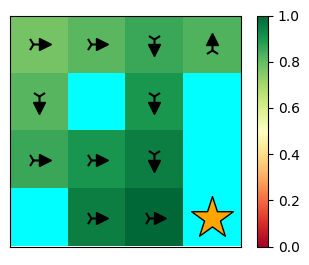

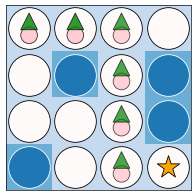

: 

In [8]:
env, dql_state, results = run_simulation(rng_key)
plotting.plot_qvals(env, dql_state.qval_apply_fn, dql_state.params_qnet, autoscale=False)
transitions = qlearning.eps_greedy_rollout(env, dql_state, rng_key, 0.0, rollout_length)
plotting.render(env, transitions.env_state)